In [121]:
import os
import numpy as np
from scipy.sparse.linalg import svds 

In [122]:
def shift_op(A_c, lam, shift_type, position ):
    A = A_c.copy()
    if shift_type == 'column':
        A[:, position] = np.roll(A[:, position], int(lam))
    if shift_type == 'vector':
        for i in range(A.shape[1]):
            A[:, i] = np.roll(A[:, i], int(lam[i]))
    return A 

def shift_op_in_fourier(A, shift, shift_type, position):
    if shift_type == 'column':
        A[:, position] = A[:, position] * np.exp(-2*np.pi * complex(0, 1)/ \
                                                A.shape[0] * np.arange(0,A.shape[0]) * shift)
    if shift_type == 'vector':
        x = np.arange(A.shape[0]).reshape(A.shape[0], 1)
        P = np.exp( - 2 * np.pi * complex(0, 1)/A.shape[0] * x @ shift.reshape(1, A.shape[1]))
        A = A * P
    return A

In [123]:
def main_algo(A, L):
    shifts = []
    u_k = []
    v_k = []
    approx = np.zeros(A.shape)
    iter_gl = 0
    iter_loc = 0
    for i in range(L):
        shift_i, iter_num_gl, iter_num_loc = shift_search(A)
        iter_gl += iter_num_gl
        iter_loc += iter_num_loc
        U, Sigma, V = svds( shift_op(A, -shift_i, 'vector', None).astype('complex'), k=1)
        u_k.append( U @ Sigma.reshape(1,1) )
        v_k.append(V)
        shifts.append(shift_i)
        approx = approx + shift_op(U @ Sigma.reshape(1, 1) @ V, shift_i, 'vector', None)
        A = A - shift_op(U @ Sigma.reshape(1,1) @ V, shift_i, 'vector', None).real
    return shifts, u_k, v_k, A, approx, iter_gl, iter_loc

In [124]:
def shift_search(A): # 3 algo
    er_input = []
    er_starting = []
    er_glob = []
    er_loc = []
    
    A_fourier = np.fft.fft(A, axis=0)
    B = np.abs(np.fft.ifft(np.abs(A_fourier) * A_fourier, axis=0))**2 
    shifts_init = np.argmax(B, axis=0) # making Initial guess for all method to find global maximum
    
    A_fourier = shift_op_in_fourier(A_fourier, -shifts_init, 'vector', None) 
    #global search
    A_fourier, shifts_glob, iter_num_gl = shift_gl_search(A_fourier, mod = 'global')
    shifts_init = shifts_init + shifts_glob 
    #local search 
    A_fourier, shifts_loc, iter_num_loc = shift_gl_search(A_fourier, mod = 'local')
    shifts =  shifts_init + shifts_loc
    #print(iter_num_gl,iter_num_loc)
    return shifts, iter_num_gl, iter_num_loc

In [58]:
def shift_gl_search(A_f, mod):
    shifts_up = np.zeros(A_f.shape[1])
    itera = 0
    U = np.zeros(A_f.shape[0]) + 1 #initial guess
    
    if mod == 'local':
        s = 1
        while s != 0 and itera < 500: 
            U,_,_ = svds(A_f, k=1, v0=U, return_singular_vectors='u') # use prefious left sing vector as Initial guess
            B = np.abs(np.fft.ifft(np.conjugate(U) * A_f,axis = 0))**2 # cross - correlation
            B = B - B[0]
            s,k= np.unravel_index(B.argmax(), B.shape)  # find max cross-corr
            A_f = shift_op_in_fourier(A_f, -s, 'column', k)# shift for minimizing metric
            shifts_up[k] += s
            itera +=1  
            
    if mod == 'global': 
        s = 1 
        U_opt,_,_ = svds(np.abs(A_f) ,k = 1) # calc u_opt - direction for searching global maximum
        
        while s!= 0 and itera < 500:
            U,_,_ = svds(A_f, k=1, v0=U, return_singular_vectors='u')
            U = U * np.abs(U_opt)/ np.abs(U) # change directon to find global minimum
            # this part is the same as for local minimum 
            B = np.abs(np.fft.ifft(np.conjugate(U) * A_f,axis = 0))**2
            B = B - B[0]
            s,k = np.unravel_index(B.argmax(), B.shape) 
            A_f = shift_op_in_fourier(A_f, -s, 'column', k)
            shifts_up[k] += s
            itera +=1
    return A_f, shifts_up, itera 

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests

url = 'https://i01.fotocdn.net/s15/239/public_pin_m/22/2393511406.jpg'
#image_raw = Image.open(requests.get(url, stream=True).raw)
image_raw = Image.open('lenna_small.png')
# image_raw = Image.open('seismic-grey.jpg')

image_raw = image_raw.convert('L')
image = np.array(image_raw).astype(np.uint8)

In [62]:
shifts, u_k, v_k, A, app, iter_gl, iter_loc = main_algo(image.astype('complex'), 3)

In [72]:
image_raw = Image.open('lenna_small.png')
image_raw = image_raw.convert('L')
image = np.array(image_raw).astype(np.uint8)
image_norm = np.linalg.norm(image, ord='fro')

errors = []
glob_iters = []
loc_iters = []
for L in range(50):
    print('L = {}'.format(L))
    _, _, _, _, app, iter_gl, iter_loc = main_algo(image.astype('complex'), L)
    glob_iters.append(iter_gl)
    loc_iters.append(iter_loc)
    error = np.linalg.norm(image-app, ord='fro')/image_norm
    errors.append(error)

L = 0
L = 1
L = 2
L = 3
L = 4
L = 5
L = 6
L = 7
L = 8
L = 9
L = 10
L = 11
L = 12
L = 13
L = 14
L = 15
L = 16
L = 17
L = 18
L = 19
L = 20
L = 21
L = 22
L = 23
L = 24
L = 25
L = 26
L = 27
L = 28
L = 29
L = 30
L = 31
L = 32
L = 33
L = 34
L = 35
L = 36
L = 37
L = 38
L = 39
L = 40
L = 41
L = 42
L = 43
L = 44
L = 45
L = 46
L = 47
L = 48
L = 49


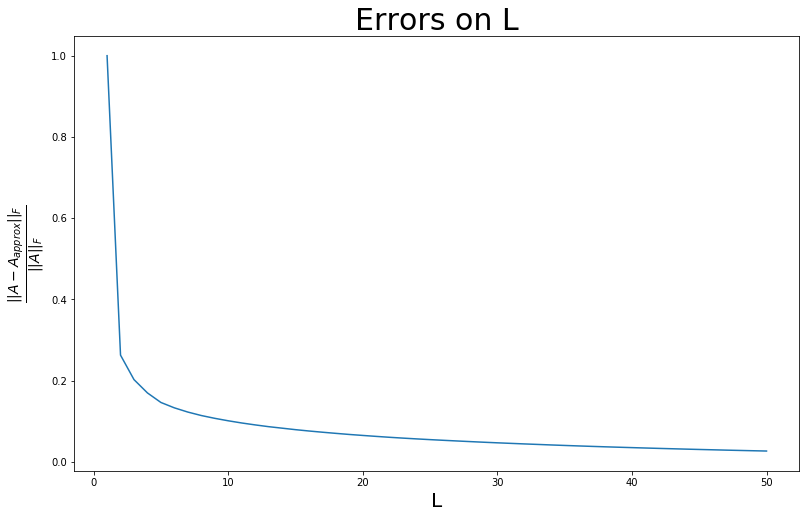

In [118]:
try:
    os.mkdir('results')
except:
    _

plt.figure(figsize=(13, 8))
plt.plot(np.arange(1, 51), errors)
plt.title("Errors on L", fontsize=30)
plt.xlabel("L", fontsize=20)
plt.ylabel("$\\frac{||A-A_{approx}||_F}{||A||_F}$", fontsize=20)

plt.savefig('./results/Errors on L.png', dpi=600)

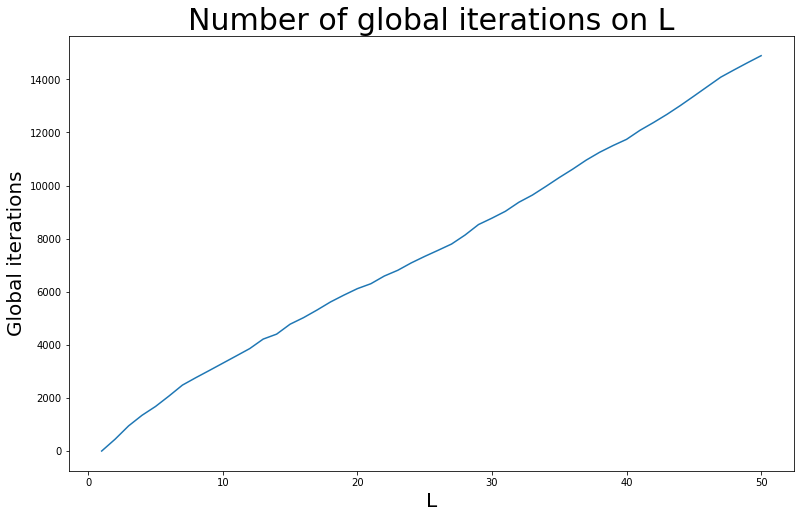

In [119]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(1, 51), glob_iters)
plt.title("Number of global iterations on L", fontsize=30)
plt.xlabel("L", fontsize=20)
plt.ylabel("Global iterations", fontsize=20)

plt.savefig('./results/Number of global iterations on L.png', dpi=600)

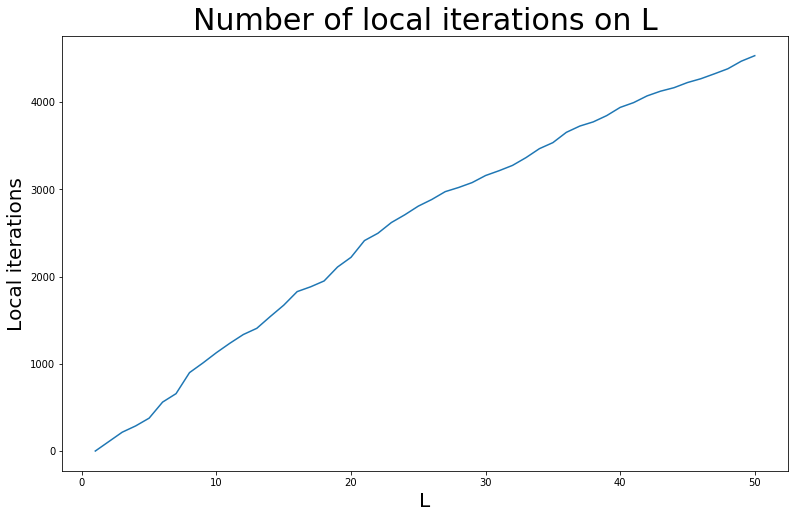

In [120]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(1, 51), loc_iters)
plt.title("Number of local iterations on L", fontsize=30)
plt.xlabel("L", fontsize=20)
plt.ylabel("Local iterations", fontsize=20)

plt.savefig('./results/Number of local iterations on L.png', dpi=600)

Now let's don't restrict the number of iterations in shift_gl_search() method to show the dependency on the size of image.

In [142]:
def shift_gl_search(A_f, mod):
    shifts_up = np.zeros(A_f.shape[1])
    itera = 0
    U = np.zeros(A_f.shape[0]) + 1 #initial guess
    
    if mod == 'local':
        s = 1
        while s != 0: 
            U,_,_ = svds(A_f, k=1, v0=U, return_singular_vectors='u') # use prefious left sing vector as Initial guess
            B = np.abs(np.fft.ifft(np.conjugate(U) * A_f,axis = 0))**2 # cross - correlation
            B = B - B[0]
            s,k= np.unravel_index(B.argmax(), B.shape)  # find max cross-corr
            A_f = shift_op_in_fourier(A_f, -s, 'column', k)# shift for minimizing metric
            shifts_up[k] += s
            itera +=1  
            
    if mod == 'global': 
        s = 1 
        U_opt,_,_ = svds(np.abs(A_f) ,k = 1) # calc u_opt - direction for searching global maximum
        
        while s!= 0:
            U,_,_ = svds(A_f, k=1, v0=U, return_singular_vectors='u')
            U = U * np.abs(U_opt)/ np.abs(U) # change directon to find global minimum
            # this part is the same as for local minimum 
            B = np.abs(np.fft.ifft(np.conjugate(U) * A_f,axis = 0))**2
            B = B - B[0]
            s,k = np.unravel_index(B.argmax(), B.shape) 
            A_f = shift_op_in_fourier(A_f, -s, 'column', k)
            shifts_up[k] += s
            itera +=1
    return A_f, shifts_up, itera 

In [147]:
dir_name = './10_pics/'
images = ['100.png', '200.png', '300.png', '400.png', '500.png',
         '600.png', '700.png', '800.png', '900.png', '1000.png']
L = 1
global_iteartions = []
local_iteartions = []
for im in images:
    image_raw = Image.open(dir_name+im)
    image_raw = image_raw.convert('L')
    image = np.array(image_raw).astype(np.uint8)
    _, _, _, _, _, iter_gl, iter_loc = main_algo(image.astype('complex'), L)
    global_iteartions.append(iter_gl)
    local_iteartions.append(iter_loc)

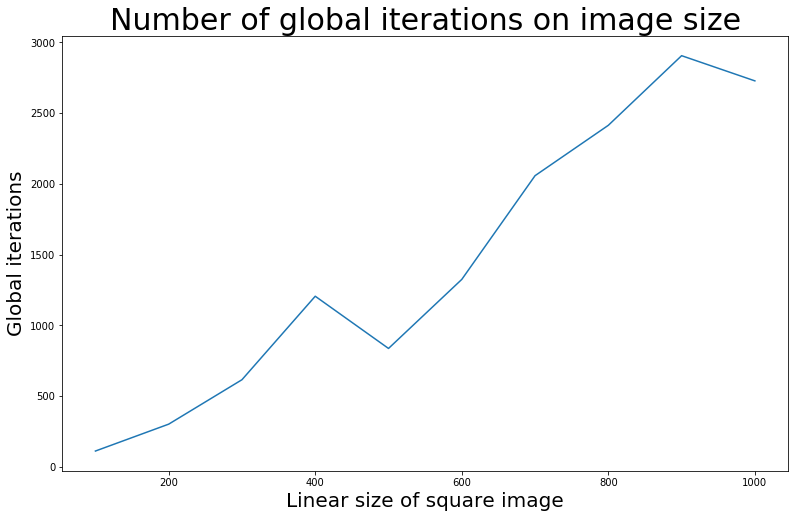

In [149]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(100, (len(global_iteartions)+1)*100, 100), global_iteartions)
plt.title("Number of global iterations on image size", fontsize=30)
plt.xlabel("Linear size of square image", fontsize=20)
plt.ylabel("Global iterations", fontsize=20)

plt.savefig('./results/Number of global iterations on image size.png', dpi=600)

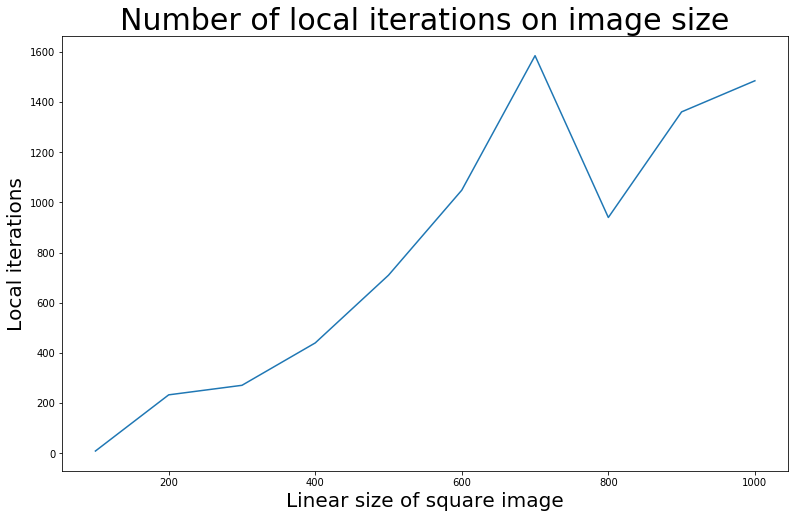

In [150]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(100, (len(global_iteartions)+1)*100, 100), local_iteartions)
plt.title("Number of local iterations on image size", fontsize=30)
plt.xlabel("Linear size of square image", fontsize=20)
plt.ylabel("Local iterations", fontsize=20)

plt.savefig('./results/Number of local iterations on image size.png', dpi=600)

## Image segmentation

(-13.151612903225786, 237.15161290322584, -5.869610007358353, 104.0)

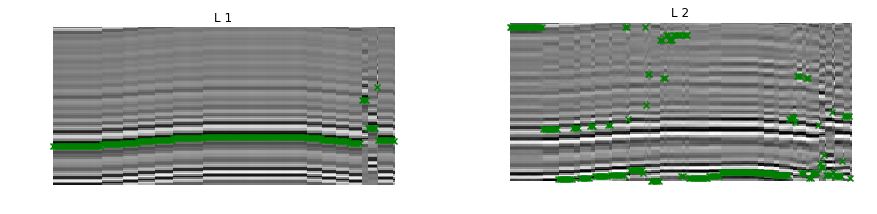

In [155]:
image_raw = Image.open('seismic-grey.jpg')
image_raw = image_raw.convert('L')
image = np.array(image_raw).astype(np.uint8)

shifts_1, _,_,_, app_1, _, _ = main_algo(image.astype('complex'), 1)
shifts_2, _,_,_, app_2, _, _ = main_algo(image.astype('complex'), 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 9)) 
ax[0].imshow(Image.fromarray(app_1.real), extent=[0, app_1.shape[1], 0, app_1.shape[0]]) 
ax[0].scatter(np.arange(app_1.shape[1]), -shifts[0]%app_1.shape[0], c='green', marker='x') 
ax[0].set_title("L 1") 
ax[0].axis('off') 

ax[1].imshow(Image.fromarray(app_2.real), extent=[0, app_2.shape[1], 0, app_2.shape[0]]) 
ax[1].scatter(np.arange(app_1.shape[1]), -shifts[1]%app_2.shape[0], c='green', marker='x') 
ax[1].set_title("L 2") 
ax[1].axis('off')